In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from numpy import pi
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def GroverCoin(qc):
    # Grover Coin operator
    qc.h([3,4])
    qc.z([3,4])
    qc.cz(3,4)
    qc.h([3,4])
    return qc

def HadamarCoin(qc):
    qc.h([3,4])
    qc.cx(3,4)
    return qc

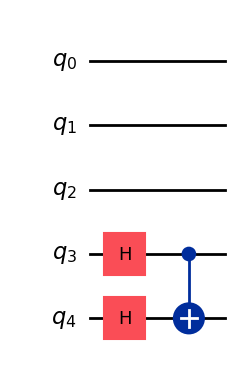

In [3]:
one_step_circuit = QuantumCircuit(5, name=' ONE STEP') 
one_step_circuit = HadamarCoin(one_step_circuit)
#one_step_circuit = GroverCoin(one_step_circuit)
one_step_circuit.draw('mpl') 


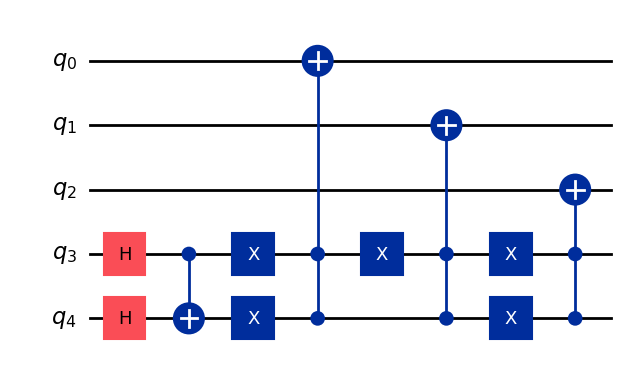

In [4]:
# Shift operator function for 4d-hypercube
def shift_operator(circuit):
    for i in range(0,3):
        circuit.x(3)
        if i%2==0:
            circuit.x(4)
        circuit.ccx(3,4,i)

shift_operator(one_step_circuit)

one_step_gate = one_step_circuit.to_instruction() 
one_step_circuit.draw('mpl') 

In [19]:
# Make controlled gates
inv_cont_one_step = one_step_circuit.inverse().control()
inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
cont_one_step = one_step_circuit.control()
cont_one_step_gate = cont_one_step.to_instruction()

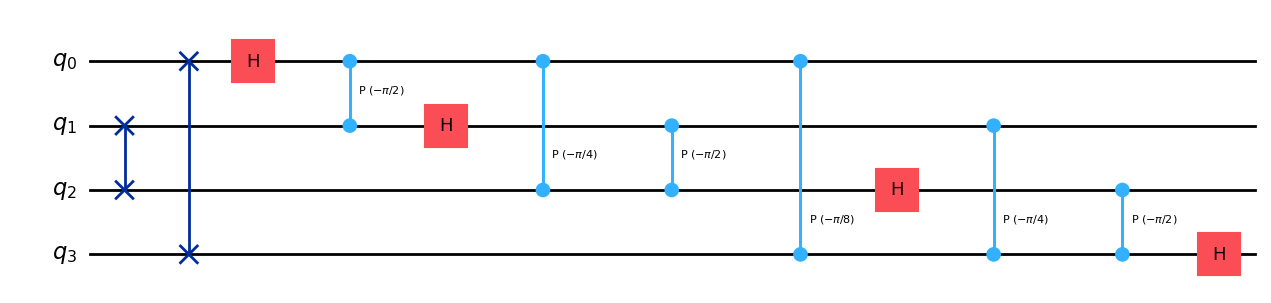

In [20]:
inv_qft_gate = QFT(4, inverse=True).to_instruction()  
qft_gate = QFT(4, inverse=False).to_instruction()

QFT(4, inverse=True).decompose().draw("mpl")

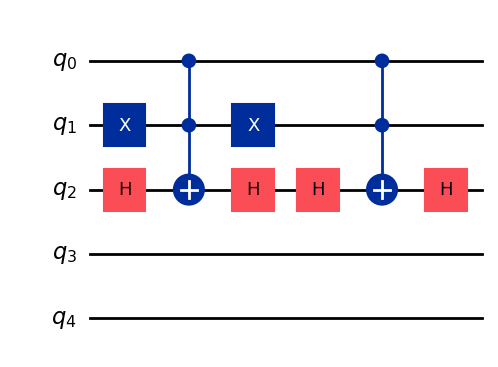

In [21]:
from qiskit.circuit.library import MCXGate

phase_circuit =  QuantumCircuit(5, name=' phase oracle ')
# Mark 101
phase_circuit.x(1)
phase_circuit.h(2)
phase_circuit.mcx([0,1],2)
phase_circuit.h(2)
phase_circuit.x(1)
# Mark 111
phase_circuit.h(2)
phase_circuit.mcx([0,1],2)
phase_circuit.h(2)
phase_oracle_gate = phase_circuit.to_instruction()
# Phase oracle circuit
phase_oracle_circuit =  QuantumCircuit(9, name=' PHASE ORACLE CIRCUIT ')
phase_oracle_circuit.append(phase_oracle_gate, [3,4,5,6,7])
phase_circuit.draw('mpl') 
#phase_oracle_circuit.draw('mpl')

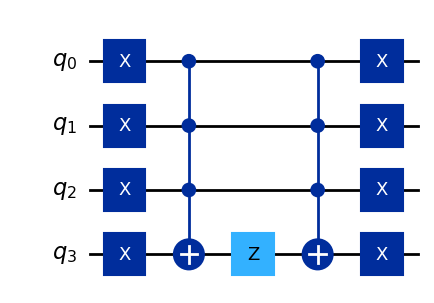

In [22]:
# Mark q_4 if the other qubits are non-zero 
mark_auxiliary_circuit = QuantumCircuit(4, name=' mark auxiliary ')
mark_auxiliary_circuit.x([0,1,2,3])
mark_auxiliary_circuit.mcx([0,1,2],3)
mark_auxiliary_circuit.z(3)
mark_auxiliary_circuit.mcx([0,1,2],3)
mark_auxiliary_circuit.x([0,1,2,3])

mark_auxiliary_gate = mark_auxiliary_circuit.to_instruction()
mark_auxiliary_circuit.draw('mpl')

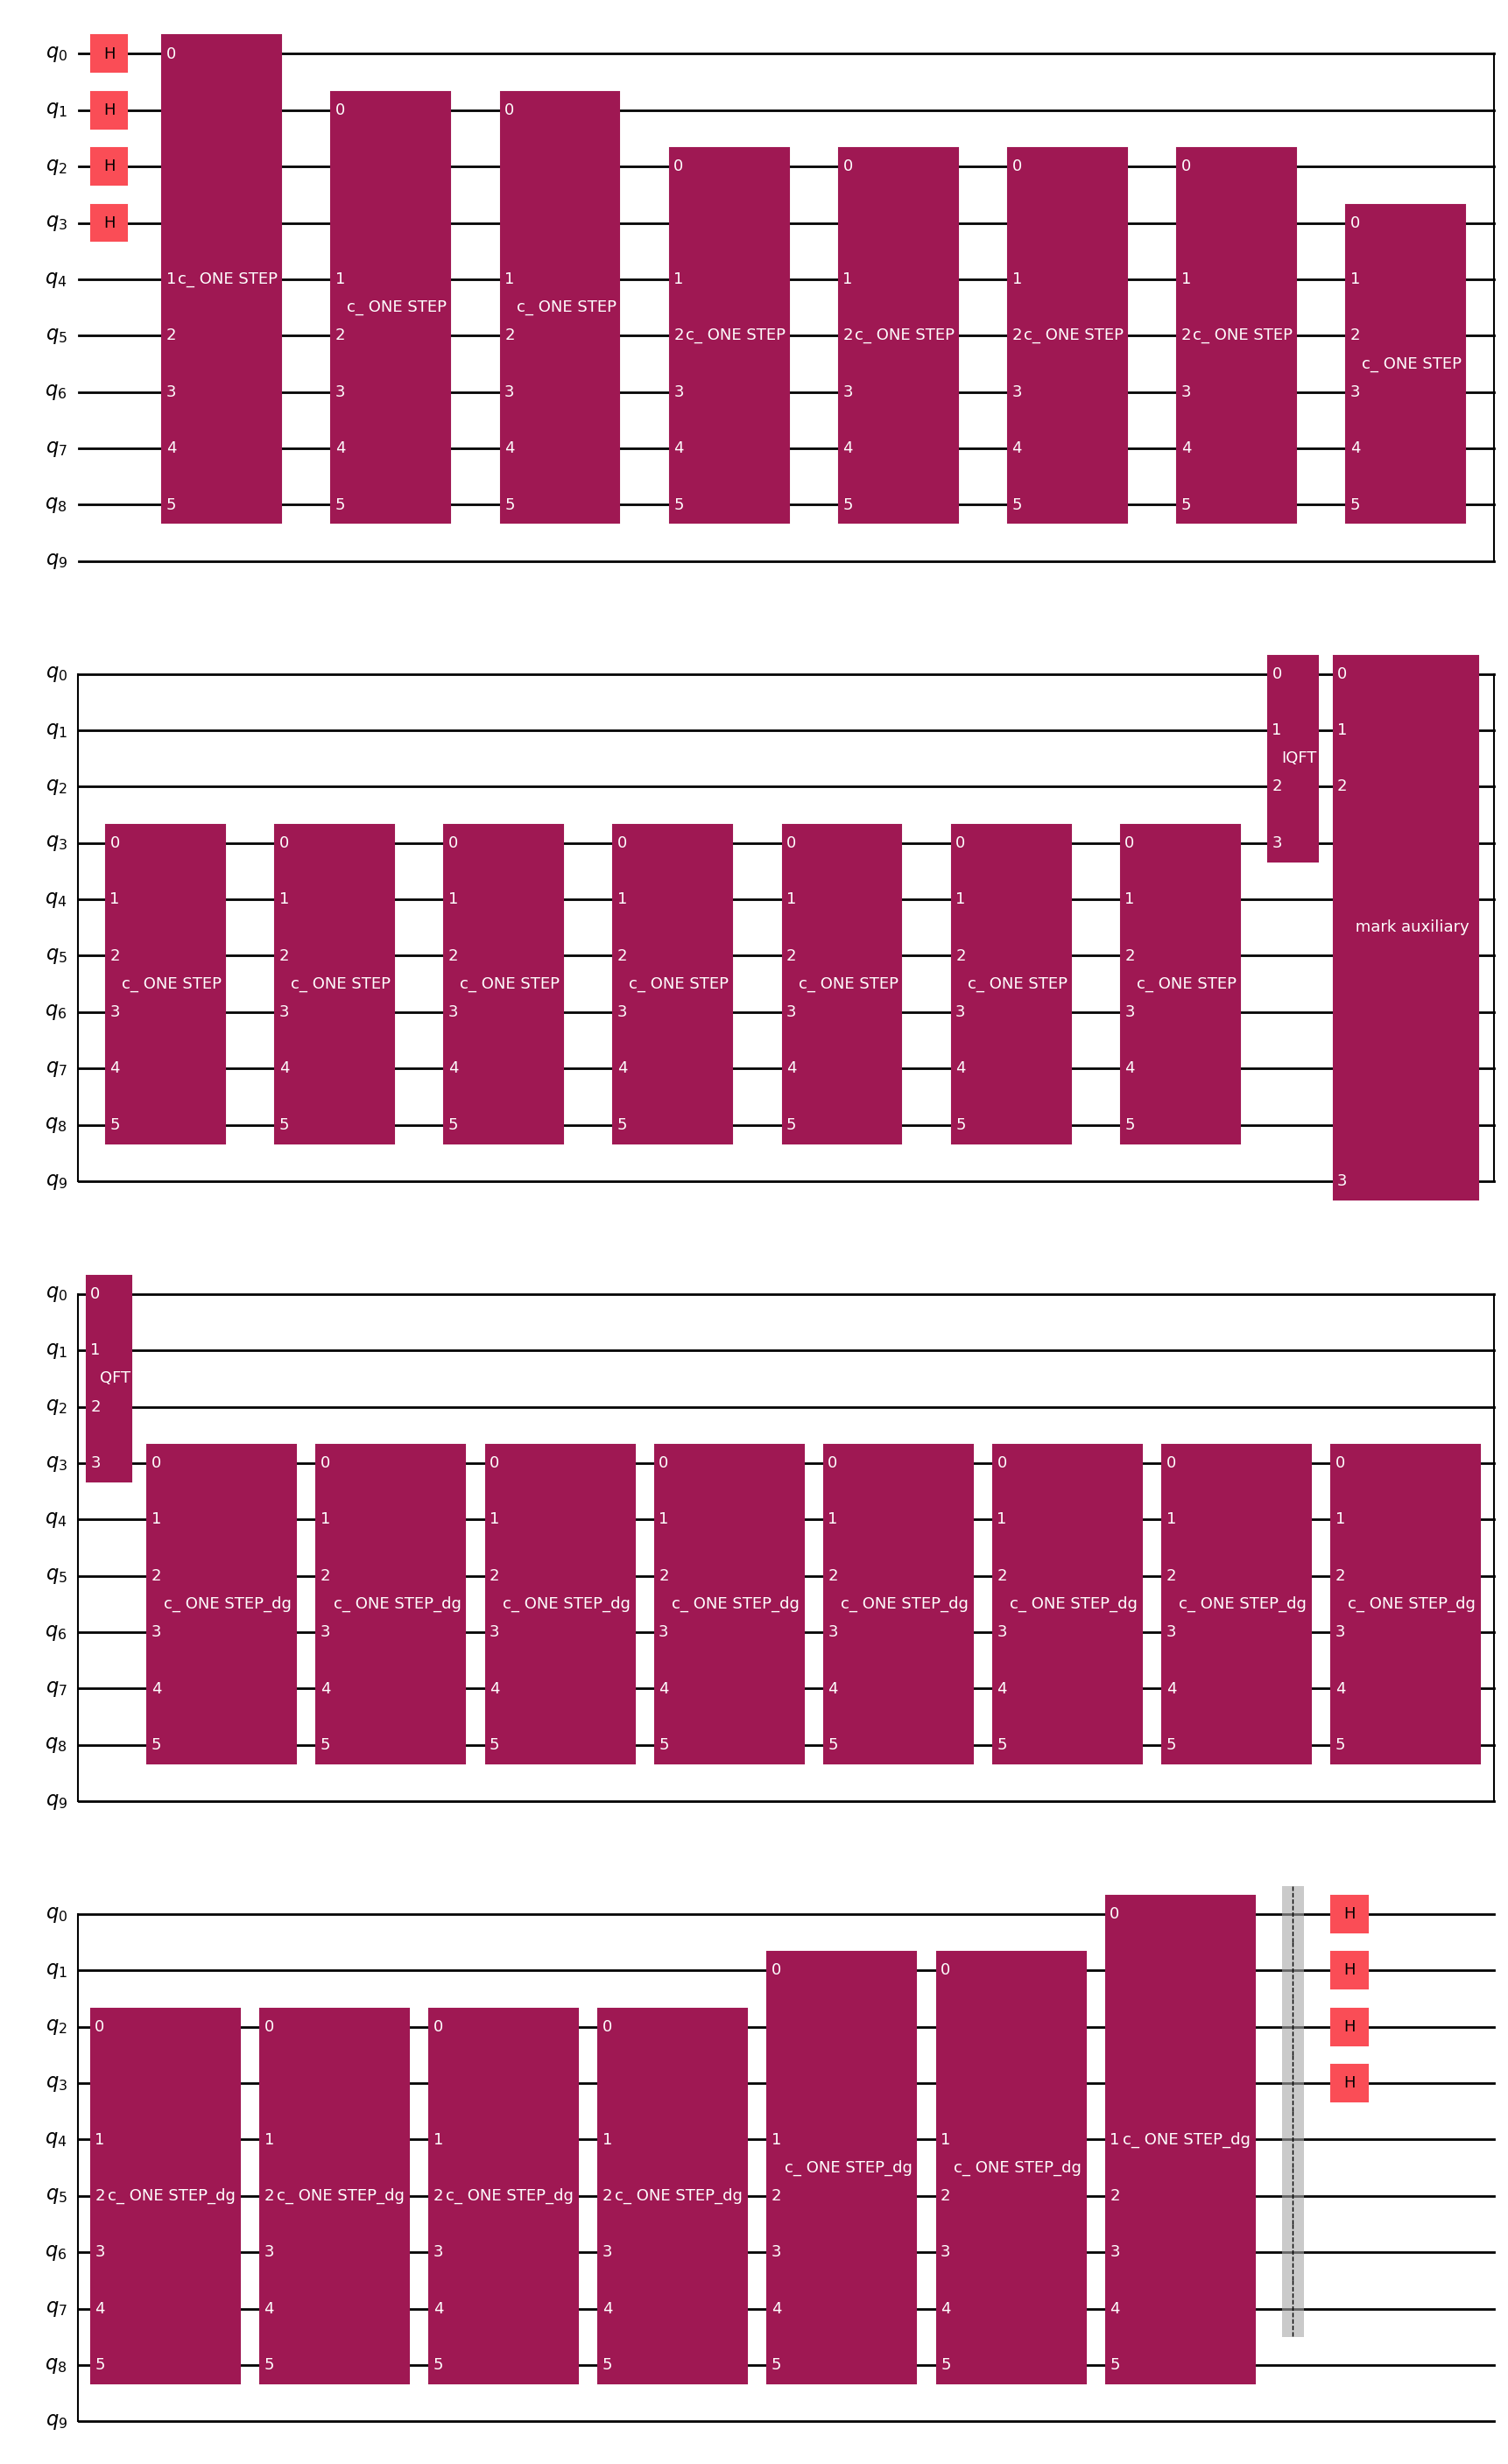

In [27]:
# Phase estimation
phase_estimation_circuit = QuantumCircuit(10, name=' phase estimation ')
phase_estimation_circuit.h([0,1,2,3])
for i in range(0,4):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(cont_one_step, [i,4,5,6,7,8])

# Inverse fourier transform
phase_estimation_circuit.append(inv_qft_gate, [0,1,2,3])

# Mark all angles theta that are not 0 with an auxiliary qubit
phase_estimation_circuit.append(mark_auxiliary_gate, [0,1,2,9])

# Reverse phase estimation
phase_estimation_circuit.append(qft_gate, [0,1,2,3])   

for i in range(3,-1,-1):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(inv_cont_one_step, [i,4,5,6,7,8])
phase_estimation_circuit.barrier(range(0,8))
phase_estimation_circuit.h([0,1,2,3])

# Make phase estimation gate
phase_estimation_gate = phase_estimation_circuit.to_instruction()
phase_estimation_circuit.draw('mpl') 

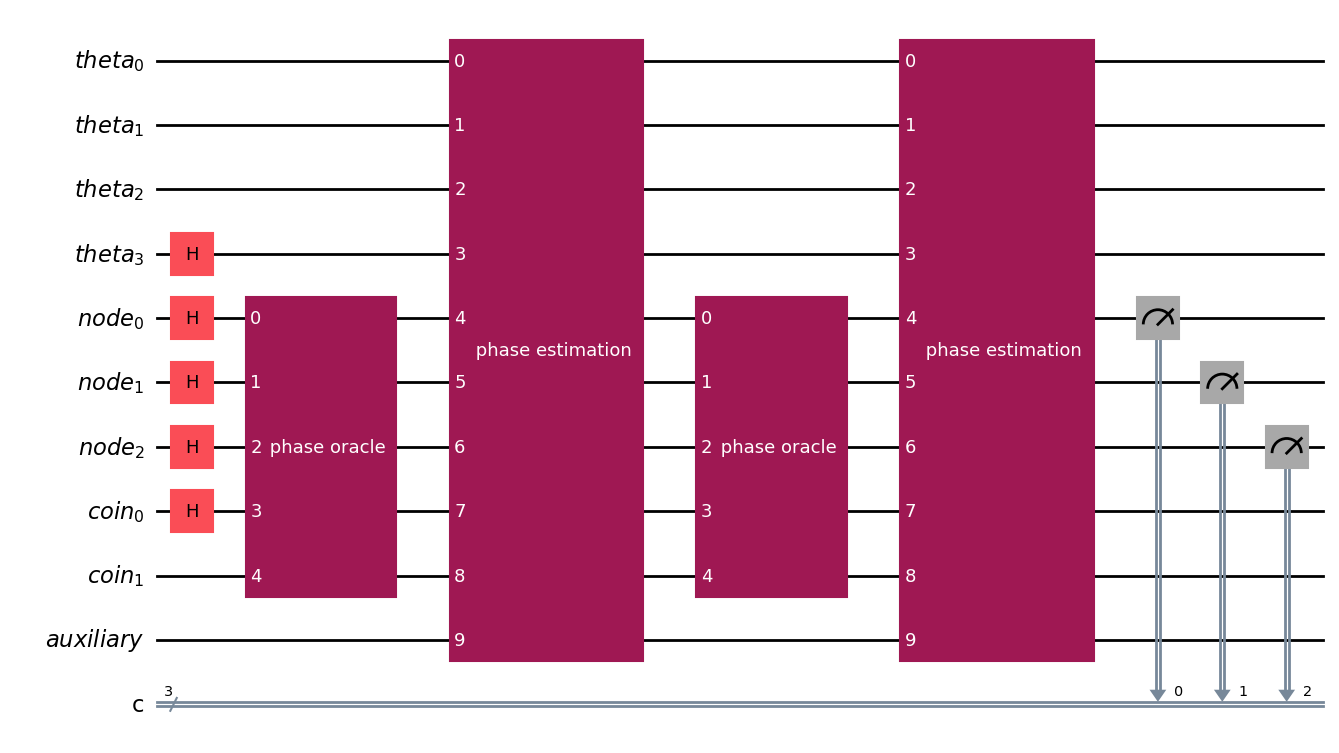

In [28]:
# Implementation of the full quantum walk search algorithm
theta_q = QuantumRegister(4, 'theta')
node_q = QuantumRegister(3, 'node')
coin_q = QuantumRegister(2, 'coin')
auxiliary_q = QuantumRegister(1, 'auxiliary')
creg_c2 = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(theta_q, node_q, coin_q, auxiliary_q, creg_c2)
# Apply Hadamard gates to the qubits that represent the nodes and the coin
circuit.h([3,4,5,6,7])
iterations = 2

for i in range(0,iterations):
    circuit.append(phase_oracle_gate, [4,5,6,7,8])
    circuit.append(phase_estimation_gate, [0,1,2,3,4,5,6,7,8,9])

circuit.measure(node_q[0], creg_c2[0])
circuit.measure(node_q[1], creg_c2[1])
circuit.measure(node_q[2], creg_c2[2])
circuit.draw('mpl')

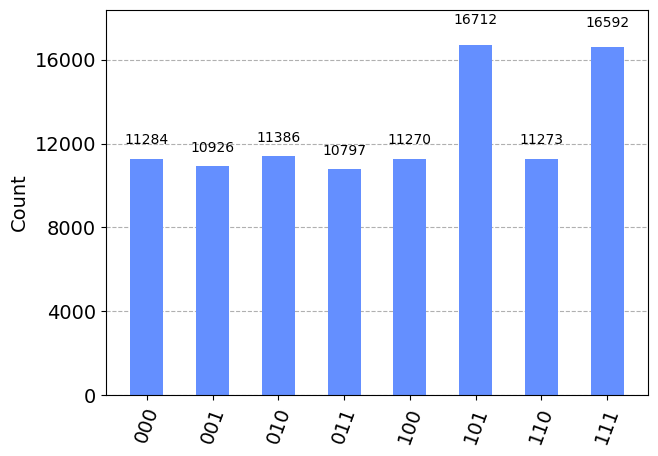

In [29]:

from qiskit_aer import AerSimulator
circuit = circuit.decompose(reps=20) #it doesn't understand big instuctions, so you have to break it up for the simulator.
job = AerSimulator().run(circuits=circuit, shots=100240)
hist = job.result().get_counts() 
plot_histogram( hist )